## Yoshi's email about PSD tracking in SCEPTER
When you are fully tracking PSD, then sa.in does not matter (it is used to specify surface areas in a simplistic way but you can assign different values to different solid species). 

The nopsd.in file should contain the solid species ids for which you do not want to fully track PSD (for instance, those species that react very fast).  So if you want to fully track PSD, then you can ignore nopsd.in file too.

PSD rain is calculated as sum of
$$w \times (1/\sigma/\sqrt(2\pi))^{-0.5((\text{log}(r) - \text{log}(r_\text{rain})/\sigma)^2)}$$
where r is radius in m and r_rain, sigma, w are the first to third column in psdrain.in file, representing average radius, sigma in log scale and fraction of the gaussian as explained in the header. 

If you give multiple rows of r_rain, sigma, w, the above equations with different r_rain, sigma, w are summed and then normalized so that PSD flux matches the mass flux specified as a dust flux.  For instance, if you get measured PSD, ideally if you choose arbitrary small sigma and scaling w to measured amount of particles with each radius bin, you can have measured PSD reflected in psdrain.in.  

---

Forgot to tell you that maximum and minimum radius is defined as 10 mm and 10 nm.  Those outside of the above range is truncated and normalized with total dust input as explained in the last email.  For loss/gain of solid species, radius less than 10 nm has to dissolve and larger than 10 mm is to increase the population of 10 mm grain. 


In [1]:
import math 
import os
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np 

# PSD for a single, gaussian distribution
The initial particle size distribution (PSD) is defined by the psdrain.in file. An example input for that file might be: 

`** mean radius [m], standard deviation in log10 [-], weight [-], gaussian parameters to define dust psd (e.g., 1e-5    0.2    1)`\
`5e-6    0.2 1`\
`20e-6   0.2 1`\
`50e-6   0.2 1`\
`70e-6   0.2 1`

where each line is a (gaussian) component of the total distribution. The full distribution is achieved by summing and normalizing the four gaussians (accounting for their weight).

The first example, for simplicity, assumes a single line (a single gaussian distribution) in the psdrain.in file.

In [2]:
# --- psd testing
r = np.linspace(1/1e6, 2e3/1e6, 100)  # [m] range of the defined PSD 
r_rain = 600 / 1e6                    # [m] mean radius of the PSD (first term in psdrain.in file)
sigma = 0.2                           # [] standard deviation in log10 (second term in psdrain.in file)
w = 1.                                # [] weight for this component of distribution (third term in psdrain.in file)
psd = w*1/sigma/np.sqrt(2*math.pi)*np.exp( -0.5*( ( np.log(r) - np.log(r_rain))/sigma )**2 )

# normalize the PDF to make sure it sums to 1 over the domain
psd /= np.trapezoid(psd, r)

# compute the CDF by integrating the PDF
cdf = np.cumsum(psd) * (r[1] - r[0])

# Find the x value where CDF crosses 0.8
p80 = r[np.searchsorted(cdf, 0.8)]

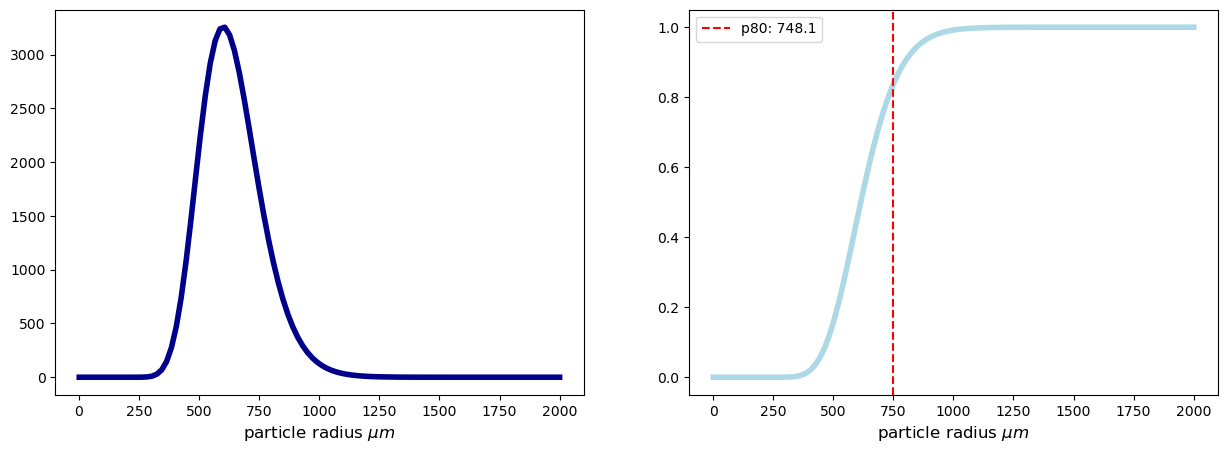

In [3]:
# --- plot the pdf and cdf 
# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=1)
fig = plt.figure(figsize=(15,5))


# --- density
ax = plt.subplot(spec[0])
plt.plot(r*1e6, psd, c='darkblue', linewidth=4)
plt.xlabel(r'particle radius $\mu m$', fontsize=12)

# --- cdf (for p80)
ax = plt.subplot(spec[1])
plt.plot(r*1e6, cdf, c='lightblue', linewidth=4)
plt.axvline(x=p80*1e6, color='red', linestyle = '--', label=f'p80: {np.round(p80*1e6, 2)}')
plt.xlabel(r'particle radius $\mu m$', fontsize=12)
plt.legend();

# Now account for the sum of multiple gaussian distributions

In [4]:
# --- psd testing
r = np.linspace(1/1e6, 2e3/1e6, 100)  # [m] range of the defined PSD 
# set up the three distributions
psd_custom = {
    "r_rain": [20/1e6, 300/1e6, 900/1e6],   # [m] mean radius of the PSD (first term in psdrain.in file)
    "sigma": [0.4, 0.2, 0.1],               # [] standard deviation in log10 (second term in psdrain.in file)
    "w": [0.1, 0.3, 1.],                      # [] weight for this component of distribution (third term in psdrain.in file)
}

# construct the PSDs
psdlist, cdflist, p80list = [], [], []
for i in range(len(psd_custom['r_rain'])):
    r_rain_tmp = psd_custom['r_rain'][i]
    sigma_tmp = psd_custom['sigma'][i]
    w_tmp = psd_custom['w'][i]
    
    # calculate psd
    psd_tmp = w_tmp*1/sigma_tmp/np.sqrt(2*math.pi)*np.exp( -0.5*( ( np.log(r) - np.log(r_rain_tmp))/sigma_tmp )**2 )
    psd_tmp /= np.trapezoid(psd_tmp, r)
    psdlist.append(psd_tmp)
    # calculate cdf
    cdf = np.cumsum(psd) * (r[1] - r[0])
    cdflist.append(cdf)
    # calculate p80
    p80list.append(r[np.searchsorted(cdf, 0.8)])

    # get weighted psd
    if i == 0:
        psd_wtdsum = psd_tmp * w_tmp
    else:
        psd_wtdsum = psd_wtdsum + (psd_tmp * w_tmp)

# get weighted cdf 
cdf_wtdsum = np.cumsum(psd_wtdsum) * (r[1] - r[0])
# get weighted p80
p80_wtdsum = r[np.searchsorted(cdf_wtdsum, 0.8)]


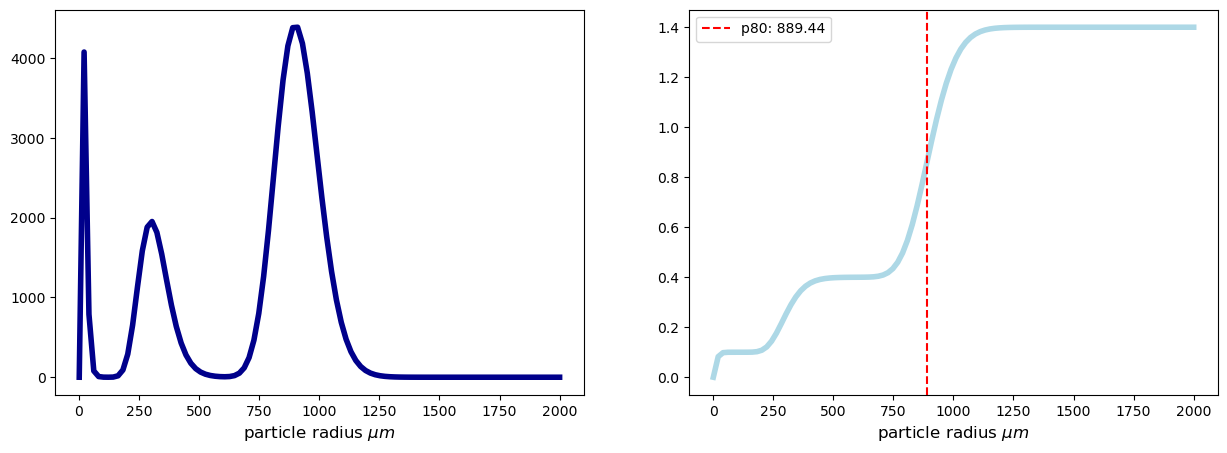

In [5]:
# --- plot the pdf and cdf 
# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=1)
fig = plt.figure(figsize=(15,5))


# --- density
ax = plt.subplot(spec[0])
plt.plot(r*1e6, psd_wtdsum, c='darkblue', linewidth=4)
plt.xlabel(r'particle radius $\mu m$', fontsize=12)

# --- cdf (for p80)
ax = plt.subplot(spec[1])
plt.plot(r*1e6, cdf_wtdsum, c='lightblue', linewidth=4)
plt.axvline(x=p80_wtdsum*1e6, color='red', linestyle = '--', label=f'p80: {np.round(p80_wtdsum*1e6, 2)}')
plt.xlabel(r'particle radius $\mu m$', fontsize=12)
plt.legend();

In [6]:
len(psd_custom["r_rain"])

3

# Create the custom psdrain.in file and save

In [8]:
# --- create a psdrain.in file from the psd dictionary and save it 
savehere = "/home/tykukla/SCEPTER/data"
savename = "psdrain_test0.in"

psd_header = "** mean radius [m], standard deviation in log10 [-], weight [-], gaussian parameters to define dust psd (e.g., 1e-5    0.2    1)\n"

# open a file for writing
with open(os.path.join(savehere, savename), "w") as file:
    # write the header
    file.write(psd_header)
    
    # iterate over the length of the lists (assuming all lists have the same length)
    for i in range(len(psd_custom["r_rain"])):
        # extract the ith element from each list
        if i < len(psd_custom["r_rain"]): # if it's not the last index, we add \n to make a new line
            line = f"{psd_custom['r_rain'][i]}\t{psd_custom['sigma'][i]}\t{psd_custom['w'][i]}\n"
        else: # otherwise don't add the line break \n
            line = f"{psd_custom['r_rain'][i]}\t{psd_custom['sigma'][i]}\t{psd_custom['w'][i]}"
        # Write the line to the file
        file.write(line)

---

## Test the make solid list function for psdrain.in

In [113]:
# 
# --- copied from make_inputs.py
#
def get_input_sld_properties(**kwargs):
    outdir      = kwargs.get('outdir',      '../scepter_output/')
    runname     = kwargs.get('runname',     'test_input')
    sld_varlist = kwargs.get('sld_varlist', [])
    filename    = kwargs.get('filename',    'kinspc.in')
    srcfile     = kwargs.get('srcfile',     None)
    
    if filename == 'kinspc.in':
        note = '** specify rate const in [mol/m2/yr] except for OMs which should be presented as turnover year [yr] (e.g., g2   1.0)'
    elif filename == 'sa.in':
        note = '** parent rock particle radii in meter (e.g., "ab      1e-5") (if not specified value in frame.in is used for all sld sp.)'
    elif filename == 'OM_rain.in':
        note = '** OM rain fraction wrt the value in frame.in (if not specified assumed 0)'
    elif filename == 'dust.in' or filename == 'dust_2nd.in':
        note = '** dusts wt fraction (if not specified assumed 0)'
    elif filename == 'cec.in':
        note = '** cec [cmol/kg], log10(KH-X) [-] (X=Na,K,Ca,Mg,Al) and beta specified by users (e.g., "g2   90   5.9   4.8   10.47   10.786   16.47   3.4") (if not specified assumed code default values)'
    elif filename == 'nopsd.in':
        note = '** list of minerals whose PSDs are not tracked for some reason'
    elif filename == '2ndslds.in':
        note = '** list of minerals whose precipitation is allowed'
    elif filename == 'psdrain.in':
        note = '** mean radius [m], standard deviation in log10 [-], weight [-], gaussian parameters to define dust psd (e.g., 1e-5    0.2    1)'
    else:
        print('{} is not supposed to be input file'.format(filename))
    
    sld_varlist.insert(0,'')
        
    
    if not os.path.exists(outdir + runname): os.makedirs(outdir + runname)
    
    if srcfile != None:
        copyfile(srcfile, outdir + runname + '/' + filename)
    else:
        
        n = len(sld_varlist)
        input_text = ''
        for i in range(n):
            if i==0:
                input_text += note + '\n'
            else:
                if filename == 'nopsd.in' or filename == '2ndslds.in':
                    input_text += sld_varlist[i][0] + '\n'
                elif filename == 'cec.in':
                    for j in range(len(sld_varlist[i])):
                        if j==0:
                            input_text += sld_varlist[i][j] + '\t' 
                        elif j==len(sld_varlist[i])-1:
                            input_text += str(sld_varlist[i][j]) + '\n' 
                        else:
                            input_text += str(sld_varlist[i][j]) + '\t'
                elif filename == 'psdrain.in':
                    for j in range(len(sld_varlist[i])):
                        if j==len(sld_varlist[i])-1:
                            input_text += str(sld_varlist[i][j]) + '\n' 
                        else:
                            input_text += str(sld_varlist[i][j]) + '\t'
                else:
                    input_text += sld_varlist[i][0] + '\t' + str(sld_varlist[i][1]) + '\n'
        
        input_file = outdir + runname + '/' + filename
        
        with open(input_file, 'w') as file:
            file.write(input_text)
        
        print(input_text)
    
    
    del sld_varlist[0]

In [121]:
sld_varlist = [[55, 555, 5555], [22,222,2222]]
modeldir = '/home/tykukla/SCEPTER'
outdir = os.path.join(modeldir, 'scepter_output')

get_input_sld_properties(
    outdir=outdir
    ,runname='__testrunname'
    ,filename = 'psdrain.in'
    ,srcfile = None, # os.path.join(modeldir, 'data', 'psdrain_100um.in'),
    sld_varlist = sld_varlist,
    )

** mean radius [m], standard deviation in log10 [-], weight [-], gaussian parameters to define dust psd (e.g., 1e-5    0.2    1)
55	555	5555
22	222	2222



In [123]:
psdrain_meanRad = 5e-6
psdrain_log10_sd = 0.2
psdrain_wt = 1.


include_psd_bulk = True
include_psd_full = False

if include_psd_bulk or include_psd_full:
    # define the source file 
    if use_psdrain_datfile:
        srcfile = os.path.join(modeldir, 'data', psdrain_datfile)
    else: 
        srcfile = None
    filename = 'psdrain.in'
    sld_varlist = [[psdrain_meanRad, psdrain_log10_sd, psdrain_wt]]
    # make (or copy) psdrain.in
    make_inputs.get_input_sld_properties(
        outdir = outdir
        ,runname = runname_field
        ,filename = filename 
        ,srcfile = srcfile
        sld_varlist = sld_varlist,
    )


yay


In [ ]:
# --- 